In [1]:
from matplotlib import pyplot as plt

In [2]:
%load_ext line_profiler

In [3]:
def plot_comparison(img1, img2, title1='img1', title2='img2', figsize=(10,10)):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize, sharex=True,
                                   sharey=True)
    ax1.imshow(img1, cmap=plt.cm.jet)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap=plt.cm.jet)
    ax2.set_title(title2)

In [11]:
import glob
import os
from linkdick06.core.dataset import Dataset

filenames = sorted(glob.glob("/nobackup/linkdick1/datasets/id06/strain/*"))[:100]
dataset_folder = "/nobackup/linkdick1/datasets/id06/"
dark_filename = os.path.join(dataset_folder, "bg_ff_5s_1x1/bg_ff_5s_1x1_0000.edf")
dataset = Dataset(filenames=filenames, dark_filename=dark_filename)

Loading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


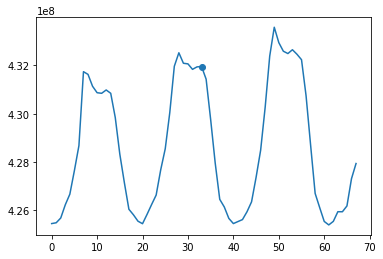

In [12]:
from linkdick06.core import imageRegistration as ir
import numpy
intensity, com = ir.compute_com(dataset.data)
plt.plot(intensity)
plt.scatter(com, numpy.sum(dataset.data[int(com)]))

In [13]:
from linkdick06.core import roi
import time
dataset.data = roi.apply_3D_ROI(dataset.data, [317, 250], [1150, 991])
# dataset.empty_frames = roi.apply_3D_ROI(dataset.empty_frames, [317, 250], [1170, 991])
dataset.dark_frames = roi.apply_3D_ROI(dataset.dark_frames, [317, 250], [1150, 991])

In [14]:
from linkdick06.core import imageOperations
dataset.data = imageOperations.background_substraction(dataset.data, dataset.dark_frames)

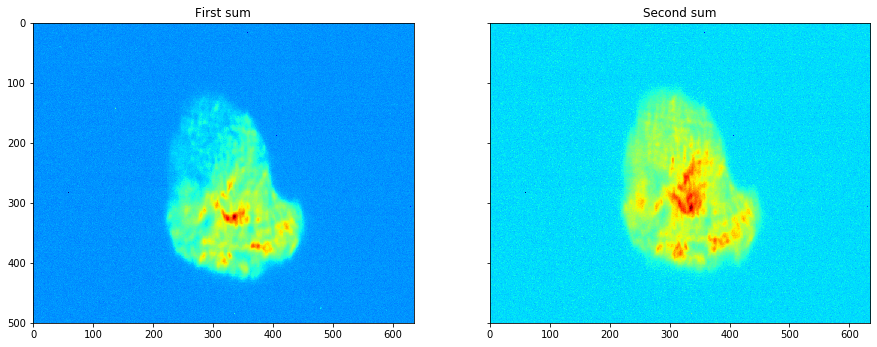

In [15]:
first_sum = numpy.sum(dataset.data[:com], axis=0)
second_sum = numpy.sum(dataset.data[com:], axis=0)
plot_comparison(first_sum, second_sum, "First sum", "Second sum", (15,15))

#### Find shift between two images using cross correlation

In [16]:
shift = ir.find_shift(first_sum, second_sum, 1000)
v1 = ir.normalize(shift)
v1

array([0.99784777, 0.06557305])

In [17]:
h1 = ir.improve_linear_shift(dataset.data, v1, 0.5, 0.01)
h1

Finding shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


0.34

In [12]:
frames = numpy.arange(dataset.data.shape[0])
v = h1*v1
%time shifted_data_scipy = ir.shift_correction(dataset.data, numpy.outer(h1*v1, frames))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 53.9 µs


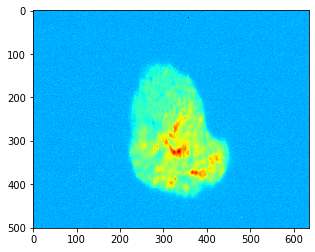

In [13]:
zsum1 = shifted_data_scipy.sum(axis=0)
plt.imshow(zsum1, cmap="jet")

#### Find shift between two images using COM

In [52]:
v2 = ir.normalize(ir.diff_com(second_sum, first_sum))
v2

array([9.99999917e-01, 4.06291218e-04])

In [43]:
h2 = ir.improve_linear_shift(dataset.data, v2, 0.5, 0.01)
h2

Finding shift module |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


0.27

In [44]:
v = h2*v2
shifted_data_com = ir.shift_correction(dataset.data, numpy.outer(h2*v2, frames))

Computing shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


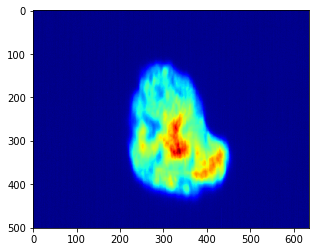

In [45]:
zsum2 = shifted_data_com.sum(axis=0)
plt.imshow(zsum2, cmap="jet")

#### Comparison

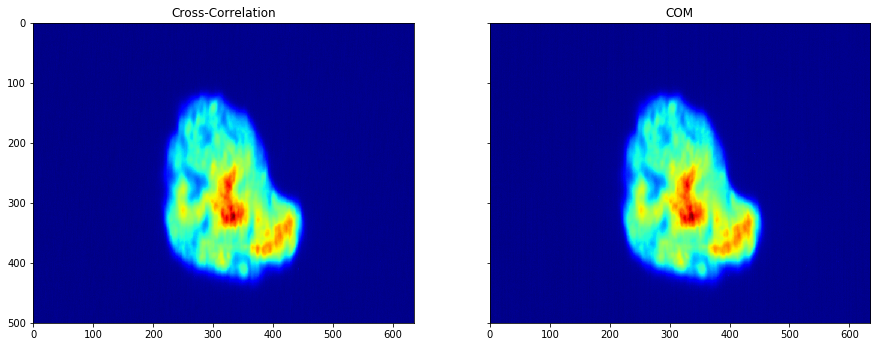

In [46]:
plot_comparison(zsum1, zsum2, "Cross-Correlation", "COM", (15,15))

In [47]:
from linkdick06.core.autofocus import normalized_variance
cmp = {"Cross-corr": normalized_variance(zsum1), "COM": normalized_variance(zsum2)}
print(cmp)

{'Cross-corr': 19597.88, 'COM': 19581.291}


#### Time using fft2 (numpy)

In [18]:
frames = numpy.arange(dataset.data.shape[0])
%time shifted_data_numpy = ir.shift_correction(dataset.data, numpy.outer(h1*v1, frames), shift_approach='fft2')

Computing shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
CPU times: user 12.9 s, sys: 616 ms, total: 13.5 s
Wall time: 13.4 s


In [19]:
zsum3 = shifted_data3.sum(axis=0)

#### Comparison time between fft and fft3 (scipy and opencv)

In [13]:
frames = numpy.arange(dataset.data.shape[0])
%time shifted_data4 = ir.shift_correction(dataset.data, numpy.outer(h1*v1, frames), shift_approach='fft3')

Computing shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
CPU times: user 7.55 s, sys: 24 ms, total: 7.57 s
Wall time: 7.56 s


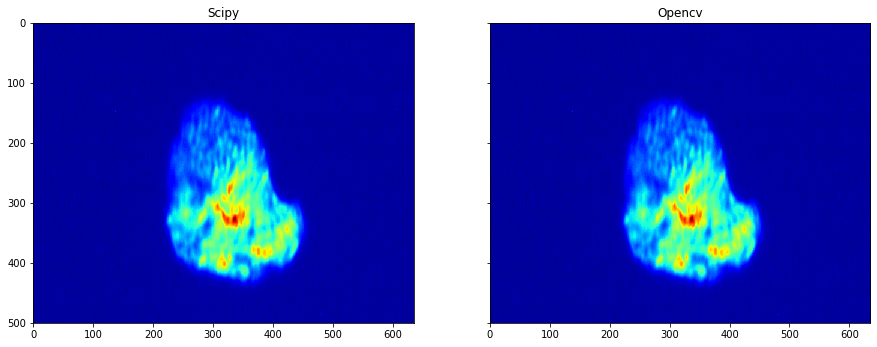

In [14]:
zsum4 = shifted_data4.sum(axis=0)
numpy.save("/users/garrigaf/Documents/tests/fft_scipy", zsum1)
numpy.save("/users/garrigaf/Documents/tests/fft_opencv", zsum4)
plot_comparison(zsum1, zsum4, "Scipy", "Opencv", (15,15))

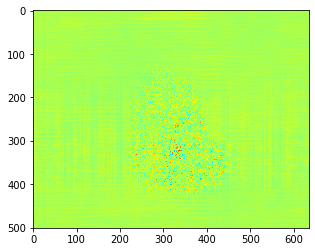

In [15]:
plt.imshow(zsum4 - zsum1, cmap="jet")

#### Compute random search using best method

In [ ]:
best_result = ir.random_search(shifted_data1, h1, v1, 300)

%time result = ir.shift_correction(dataset.data, best_result)

In [ ]:
zsum_r = result.sum(axis=0)
plt.imshow(zsum_r1, cmap="jet")

#### Genetic algorithm

In [ ]:
from linkdick06.core.ga import GA
ga = GA(dataset.data).fit((0,0), h1/2, 10)
 ga.support_